# Titanic Decision Trees

## The Data

The dataset used in this project is sourced [here](https://www.kaggle.com/c/titanic/data).

It contains the following variables:
* **PassengerId** 
* **Survived:** 0 = No, 1 = Yes
* **Pclass:** ticket class. 1 = 1st, 2 = 2nd, 3 = 3rd
* **Name**
* **Sex**
* **Age**
* **SibSp:** number of siblings / spouses aboard
* **Parch:** number of parents / children aboard
* **Ticket:** ticket number
* **Fare:** passenger fare
* **Cabin:** cabin number
* **Embarked:** port of embarkation. C = Cherbourg, Q = Queenstown, S = Southampton

## Objective

In this project I aim to create a Decision Tree that can predict the survival of passengers on the Titanic, based on data about each passenger's age, sex, ticket class etc. First I will not impose any restrictions on the depth of the tree, but then I will try building the model for different depths and see how this affects accuracy.

Further in the project, I develop my model using ensemble methods which combine the predictions of multiple decision trees in order to improve the overall performance and accuracy of the model. Finally, I analyse which method generated the highest score for accuracy.

## Loading & Preprocessing

In [57]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [58]:
# Import data
titanic_df = pd.read_csv("titanic.csv")
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [59]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


There are 891 records in the data and 12 columns. All of the data types look to be appropriate for their respective attributes.

In [60]:
# Check for duplicates
duplicates = titanic_df.duplicated()
print(titanic_df[duplicates])

Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked]
Index: []


No duplicate records were found. 

Some of these columns are not going to be very useful in my analysis, and so I drop these columns, and then check for for missing values.

In [61]:
# Drop irrelevant columns
titanic_df.drop(["PassengerId", "Cabin", "Name", "Ticket"], axis = 1, inplace = True)

In [62]:
# Check for missing values now
titanic_df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

Since there are 177 missing values of Age, this equates to roughly 20% of the data and so dropping these rows could lead to a loss of valuable data. Instead, I will fill in the missing values using the median age.

In [63]:
titanic_df['Age'] = titanic_df['Age'].fillna(titanic_df['Age'].median())

Since there are only 2 values missing for 'Embarked', I will simply drop these two records.

In [64]:
titanic_df = titanic_df.dropna(subset = ['Embarked'])

### One-Hot Encoding
One-hot encoding is a technique used to ensure that categorical variables are better represented in the machine. Let's take a look at the "Sex" column:

In [65]:
titanic_df["Sex"].unique()

array(['male', 'female'], dtype=object)

Since Machine Learning classifiers don't know how to handle strings, I will need to convert this column into a categorical representation. I will do this using One-hot encoding, which can be executed in pandas like so:

In [66]:
titanic_df = pd.get_dummies(titanic_df, prefix = "Sex", columns = ["Sex"])
titanic_df[['Sex_female', 'Sex_male']] = titanic_df[['Sex_female', 'Sex_male']].astype(int)
titanic_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex_female,Sex_male
0,0,3,22.0,1,0,7.2500,S,0,1
1,1,1,38.0,1,0,71.2833,C,1,0
2,1,3,26.0,0,0,7.9250,S,1,0
3,1,1,35.0,1,0,53.1000,S,1,0
4,0,3,35.0,0,0,8.0500,S,0,1


The Sex column has been split into two columns, Sex_female and Sex_Male, where Sex_female will contain a '1' if the Sex of the passenger is female, for example.

Now, we do the same to the "Embarked" column.

In [67]:
titanic_df = pd.get_dummies(titanic_df, prefix = "Embarked", columns = ["Embarked"])
titanic_df[['Embarked_C', 'Embarked_Q', 'Embarked_S']] = titanic_df[['Embarked_C', 'Embarked_Q', 'Embarked_S']].astype(int)
titanic_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


## Training the Tree

In [68]:
# Independent Variables
X = titanic_df.drop(columns = "Survived")

# Dependent Variable
y = titanic_df['Survived']

Now I have selected relevant variables from the data I will split the data into a training, development and test set. This is done in two stages:

In [69]:
# Split the original dataset into training and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)

# Split the training set further into training and development sets
X_train, X_dev, y_train, y_dev = train_test_split(X_train_full, y_train_full, test_size = 0.2, random_state = 3)

The development set will be used for tuning the model's hyperparameters like max_depth. First, I create and train the decision tree model without imposing restrictions on depth - creating an unpruned tree.

In [70]:
# Create classifier
tree_model = DecisionTreeClassifier(random_state = 3)

# Train the classifier on your training data
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=3)

Now I will plot the trained decision tree:

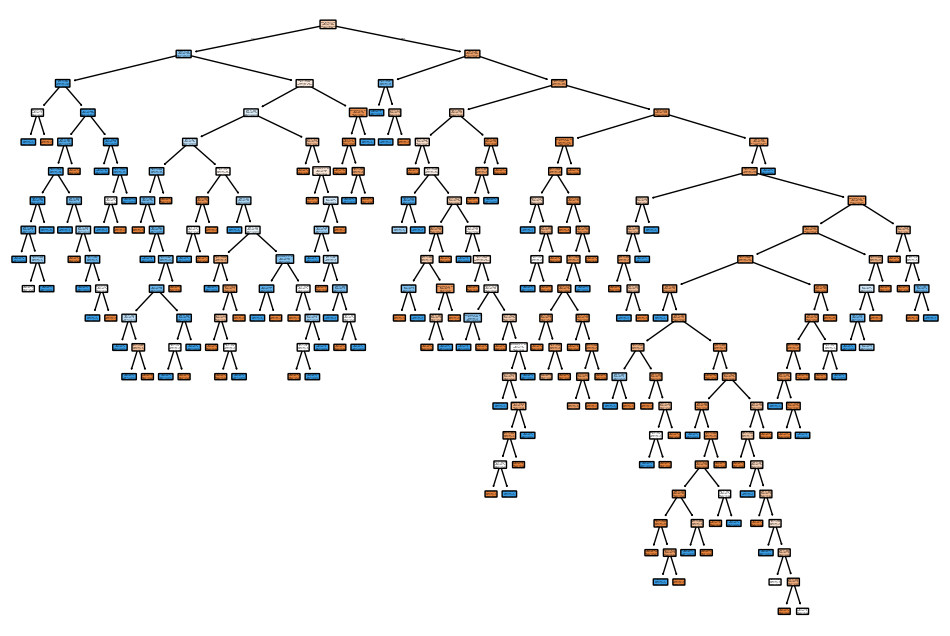

In [71]:
plt.figure(figsize=(12, 8))
plot_tree(tree_model, filled = True, feature_names = X.columns, class_names = ['Died', 'Survived'], rounded = True)
plt.show()

Now, I will compute the model's accuracy on the development set.

In [72]:
# Predict on the development set
y_pred_dev = tree_model.predict(X_dev)

# Accuracy on development set
accuracy_dev = accuracy_score(y_dev, y_pred_dev)
print(f"Accuracy on development set: {accuracy_dev:.3f}")

Accuracy on development set: 0.818


## Varying Tree Depths

Next, I will train the decision tree model with different values of max_depth and evaluate it on both the training and development sets. I'll plot the decision tree for each value of max_depth to visualise how it changes with increasing complexity. Then, I'll plot the tracked training and development accuracies on a graph.

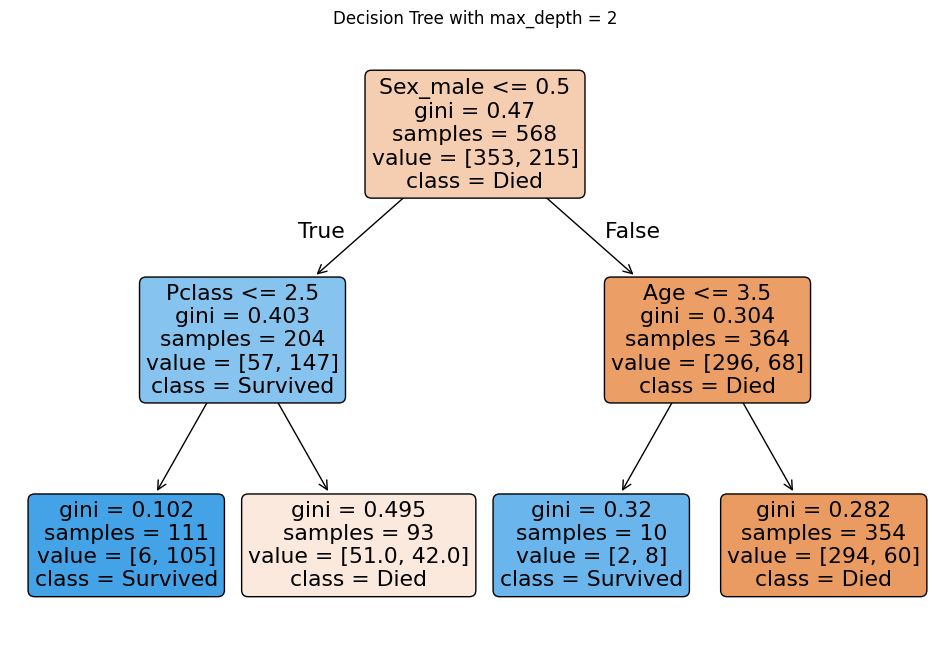

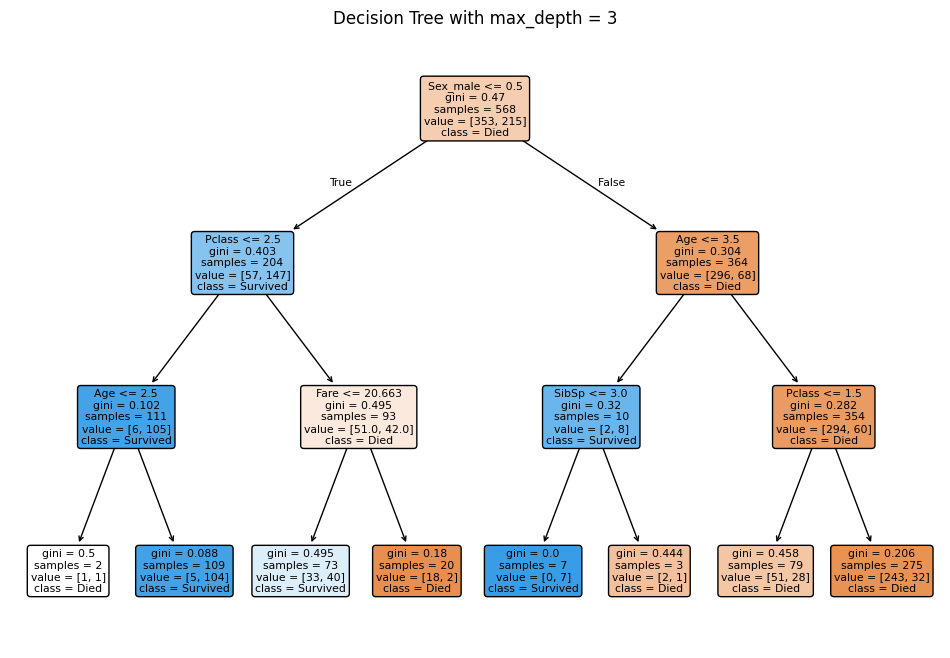

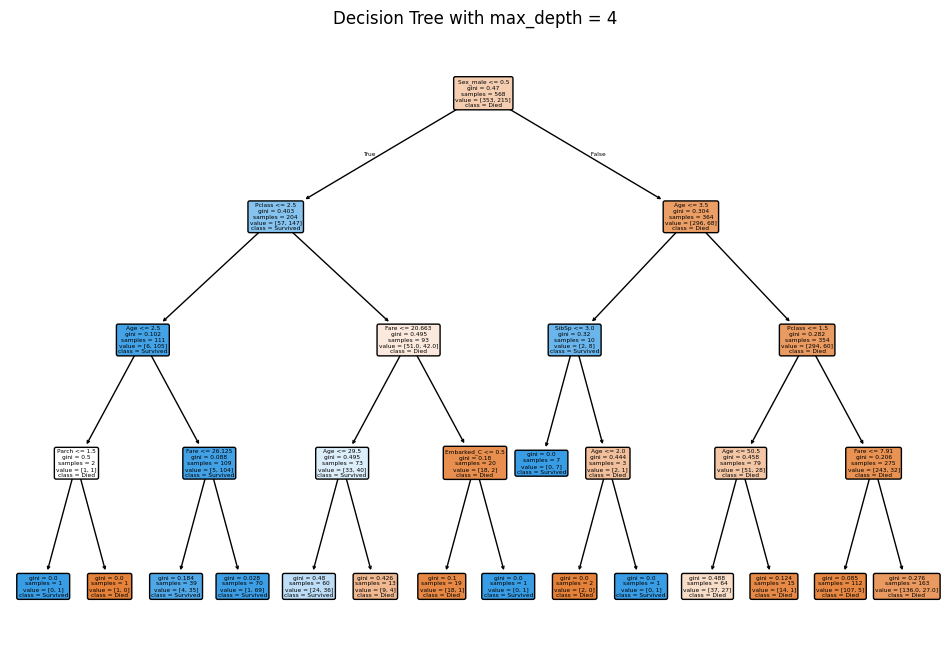

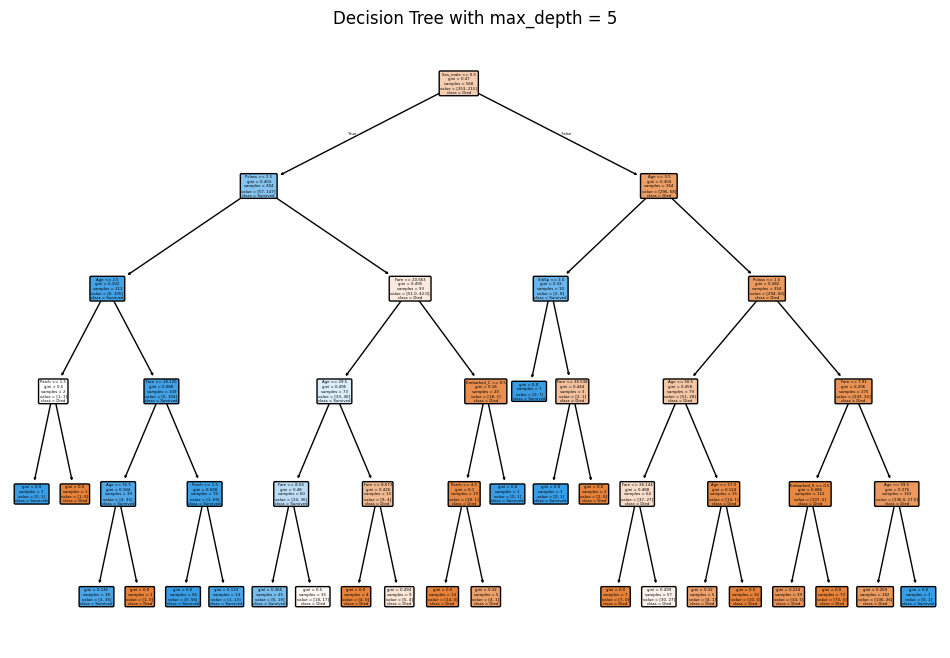

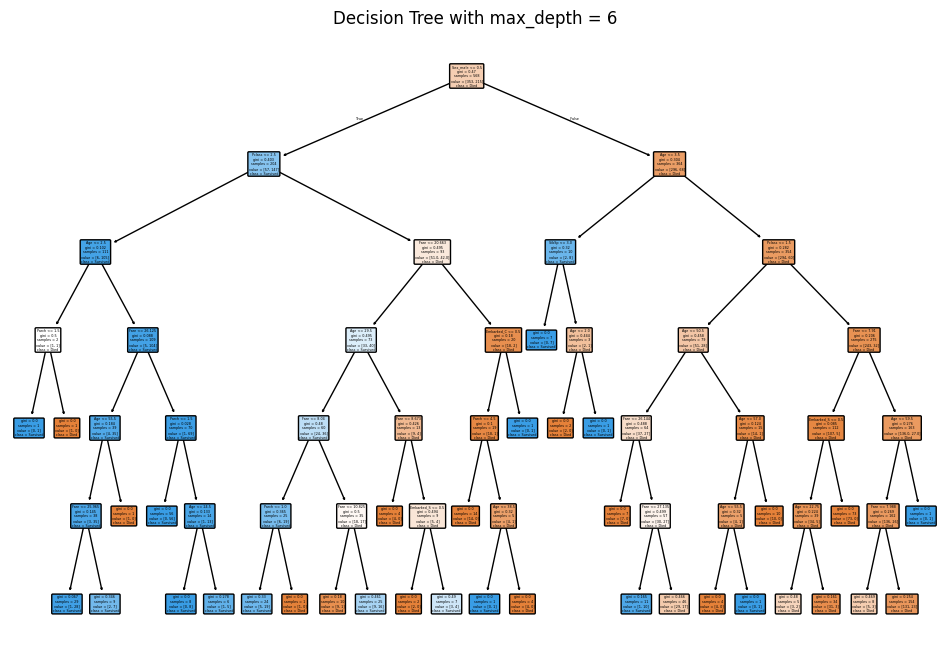

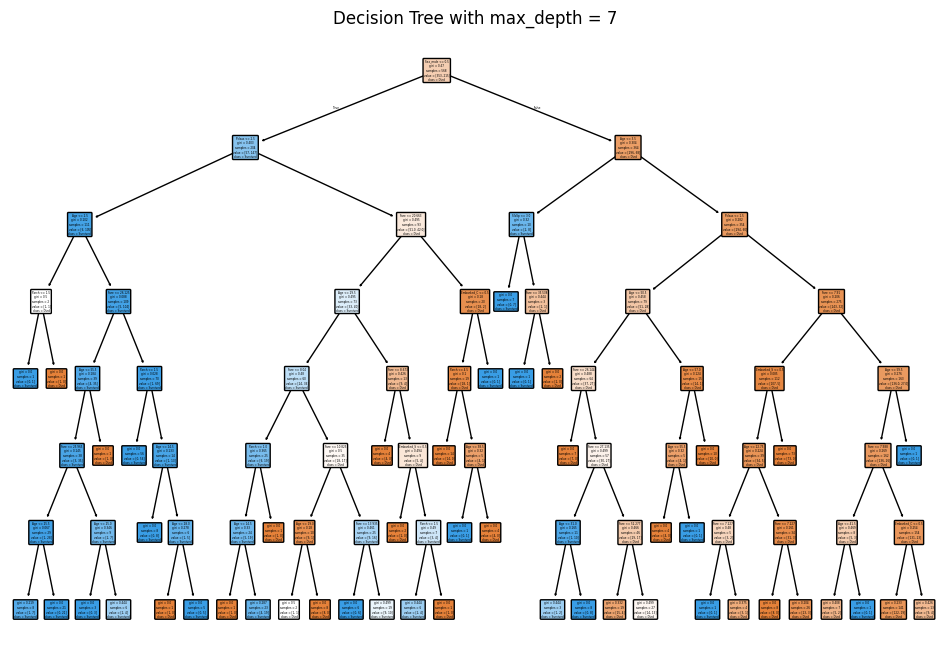

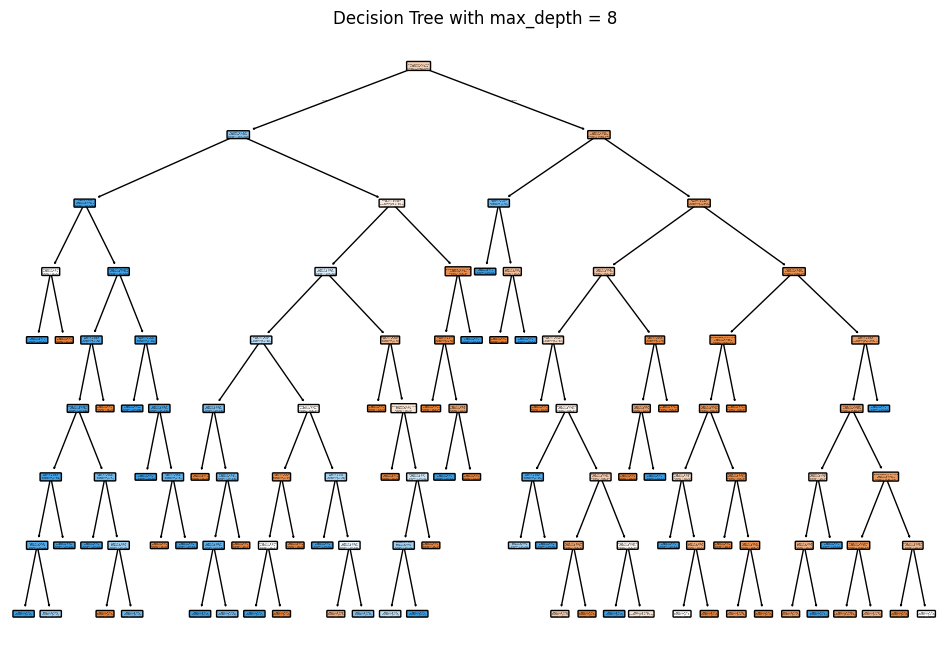

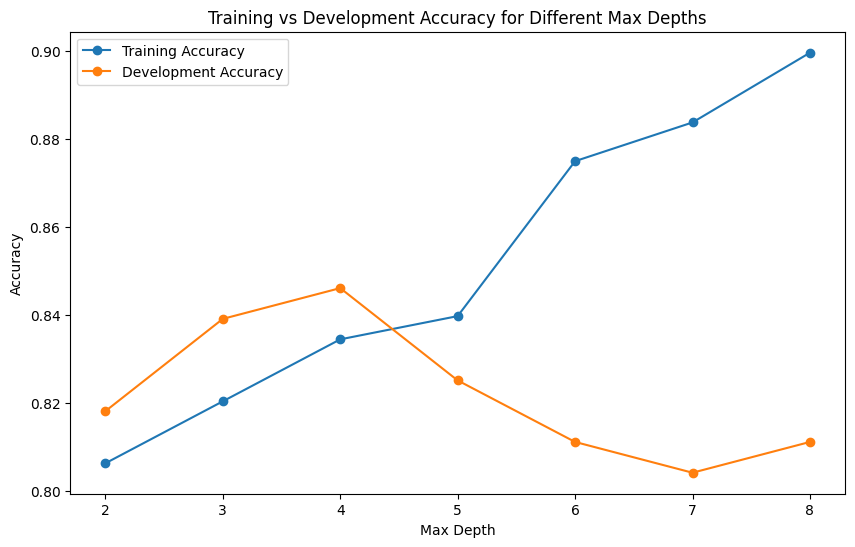

In [73]:
# Store training and development accuracies
train_accuracies = []
dev_accuracies = []
depths = range(2, 9)

for depth in depths:
    tree_model = DecisionTreeClassifier(max_depth = depth, random_state = 3)
    tree_model.fit(X_train, y_train)

    # Training accuracy
    y_pred_train = tree_model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_accuracies.append(train_accuracy)

    # Development accuracy
    y_pred_dev = tree_model.predict(X_dev)
    dev_accuracy = accuracy_score(y_dev, y_pred_dev)
    dev_accuracies.append(dev_accuracy)

    # Plot the decision tree for each depth
    plt.figure(figsize=(12, 8))
    plot_tree(tree_model, filled = True, feature_names = X.columns, class_names = ['Died', 'Survived'], rounded = True)
    plt.title(f"Decision Tree with max_depth = {depth}")
    plt.show()

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(depths, train_accuracies, label = 'Training Accuracy', marker = 'o')
plt.plot(depths, dev_accuracies, label = 'Development Accuracy', marker = 'o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Development Accuracy for Different Max Depths')
plt.show()

As max_depth increases, the training accuracy continues to improve, which is expected as the model becomes more complex and overfits the training data. The development accuracy initially increases as the model becomes more capable of fitting the data, but after max_depth = 4, it decreases as the model starts to overfit. So the point at which max_depth peaks should be where the model has a good balance of fitting to the training data and generalising to the development set.

So after selecting the best max_depth on the development set, finally I will use this to evaluate the final model on the test set.

In [74]:
# Choose the best max_depth value based on development accuracy
best_depth = depths[np.argmax(dev_accuracies)]

# Train the model with the best max_depth
final_model = DecisionTreeClassifier(max_depth = best_depth, random_state = 3)
final_model.fit(X_train, y_train)

# Evaluate on the test set
y_pred_test = final_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Final accuracy on the test set: {accuracy_test:.3f}")

Final accuracy on the test set: 0.803


# Ensemble Methods

In this section, I will create a Bagged, Random Forest, and Boosted tree for the titanic dataset. These are all examples of Ensemble Methods, which combine the predictions of multiple decision trees. I will report on the performance of each model in predicting passenger survival.

## Bagging Classifier

Bagging is an ensemble method that trains multiple decision trees on different subsets of the data (through bootstrapping) and aggregates their predictions. The aim is to reduce variance by averaging the predictions of many models.

In [75]:
# Independent Variables
X = titanic_df.drop(columns = "Survived")

# Dependent Variable
y = titanic_df['Survived']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 3)

Now, I create the Base Model - which is a single decision tree, and use this to create the Bagged Model. Both of the models are trained, and then I compute the accuracy of each on the test set.

In [76]:
# Create base and bagging model
base = DecisionTreeClassifier(max_depth = 6, random_state = 3)
bagging_model = BaggingClassifier(estimator = base, n_estimators = 100, random_state = 3)

# Train both models
base.fit(X_train,y_train)
bagging_model.fit(X_train,y_train)

# Evaluate the base model on the test set
base_accuracy = base.score(X_test, y_test)
print(f"Base Model Accuracy on Test Set: {base_accuracy:.3f}")

# Evaluate the bagging model on the test set
bagging_accuracy = bagging_model.score(X_test, y_test)
print(f"Bagging Model Accuracy on Test Set: {bagging_accuracy:.3f}")

Base Model Accuracy on Test Set: 0.776
Bagging Model Accuracy on Test Set: 0.798


## Random Forest Model

This is essentially an ensemble of decision trees trained using bagging, but it also includes a feature selection when creating each tree.

In [77]:
# Create and train the model
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 3)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=3)

In [78]:
# Evaluate the Random Forest model on the test set
test_accuracy_rf_first = rf_model.score(X_test, y_test)
print(f"Initial Random Forest Accuracy on Test Set: {test_accuracy_rf_first:.3f}")

Initial Random Forest Accuracy on Test Set: 0.771


Since Random Forest benefits from working with a smaller set of more relevant features, I am going to use its method for ranking feature importance and then remove the 'least important' features in X.

In [79]:
# Print importance scores for features alongside feature names
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
feature_importance_df = feature_importance_df.sort_values(by = 'Importance', ascending = False)
print(feature_importance_df)

      Feature  Importance
4        Fare    0.239594
1         Age    0.232994
6    Sex_male    0.157305
5  Sex_female    0.135933
0      Pclass    0.108349
2       SibSp    0.047512
3       Parch    0.037831
9  Embarked_S    0.016675
7  Embarked_C    0.016058
8  Embarked_Q    0.007749


This shows that according to the Random Forest Classifier, 'Fare' is the feature that contributes the most to predicting whether a passenger survives or not. The 3 least important, which are the values for 'Embarked' (relating to the port of embarkation - Cherbourg, Queenstown or Southampton), contributed less than 2% each. Therefore, I will remove these bottom three features in the hope to reduce noise and improve performance.

In [80]:
# select important features
X = X.iloc[:, :7]

# retrain 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 3)
rf_model.fit(X_train, y_train)

test_accuracy_rf = rf_model.score(X_test, y_test)
print(f"Random Forest (reduced features) Accuracy on Test Set: {test_accuracy_rf:.3f}")

Random Forest (reduced features) Accuracy on Test Set: 0.771


Since the accuracy has not changed, it's likely these features were not significantly impacting the model's performance.

## Boosted Tree

Boosting builds trees sequentially, where each tree tries to correct the errors of the previous one. To use this method, I'll first reset my variables so that X contains all 10 original features again (3 were removed in above section). This will enable me to compare each model fairly.

In [81]:
# Independent Variables
X = titanic_df.drop(columns = "Survived")

# Dependent Variable
y = titanic_df['Survived']

# Split the original dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 3)

In [82]:
# Create and train the Gradient Boosting model
boosting_model = GradientBoostingClassifier(n_estimators = 100, random_state = 3)
boosting_model.fit(X_train, y_train)

# Evaluate the Boosting model on the test set
test_accuracy_boosting_first = boosting_model.score(X_test, y_test)
print(f"Boosting Model Accuracy on Test Set: {test_accuracy_boosting_first:.3f}")

Boosting Model Accuracy on Test Set: 0.771


For this method, I will tune the parameters n_estimators and max_depth and see for which values the model performs the best. To do this I will use GridSearchCV to perform cross-validation over these values and find the best combination.

In [83]:
# Define a parameter grid to search over
# Try different values for each parameter
param_grid = {
    'n_estimators': [75, 100, 125, 150],
    'max_depth': [3, 4, 5, 6]
}

# Create the model
boosting_model = GradientBoostingClassifier(random_state = 3)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator = boosting_model, param_grid = param_grid, 
                           cv = 5, n_jobs = -1, scoring = 'accuracy', verbose = 0)

# Fit to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and best score
print("Best hyperparameters found by GridSearchCV:", grid_search.best_params_)
print(f"Best cross-validation accuracy: {grid_search.best_score_:.3f}")

# Get the best model and evaluate on test set
best_boosting_model = grid_search.best_estimator_
test_accuracy_boosting_best = best_boosting_model.score(X_test, y_test)
print(f"Boosting Model Accuracy on Test Set (Best Model): {test_accuracy_boosting_best:.3f}")

Best hyperparameters found by GridSearchCV: {'max_depth': 4, 'n_estimators': 125}
Best cross-validation accuracy: 0.841
Boosting Model Accuracy on Test Set (Best Model): 0.812


This tells me that out of the parameters I provided, the best values for 'max_depth' and 'n_estimators' to use to increase accuracy of the boosted model is 4, and 125, respectively. This achieves an accuracy score of 0.812 on the test set.

## Comparing Model Performance

I can now print compare the accuracy of all models used:

In [84]:
print(f"Decision Tree Accuracy on Test Set: {base_accuracy:.3f}")
print(f"Bagging Model Accuracy on Test Set: {bagging_accuracy:.3f}")
print(f"Initial Random Forest Accuracy on Test Set: {test_accuracy_rf_first:.3f}")
print(f"Random Forest (reduced features) Accuracy on Test Set: {test_accuracy_rf:.3f}")
print(f"Boosting Model Accuracy on Test Set: {test_accuracy_boosting_first:.3f}")
print(f"Tuned Boosting Model Accuracy on Test Set: {test_accuracy_boosting_best:.3f}")

Decision Tree Accuracy on Test Set: 0.776
Bagging Model Accuracy on Test Set: 0.798
Initial Random Forest Accuracy on Test Set: 0.771
Random Forest (reduced features) Accuracy on Test Set: 0.771
Boosting Model Accuracy on Test Set: 0.771
Tuned Boosting Model Accuracy on Test Set: 0.812


In summary, the Bagging Model slightly improved performance of the Decision Tree, achieving 79.8% accuracy. The Random Forest Model only scored 77.1%,and did not improve by removing the features of least importance. The Boosted Model initially was similar, however after hyperparameter tuning it significantly improved in accuracy Overall, the model that performed best was the Boosted Model, tuned with max_depth = 4 and n_estimators = 125.